# Grover's Search by Quantum Singular Value Transformation (QSVT)

#### Valter Uotila

This is the Pennylane implementation of the code in https://github.com/bartubisgin/QSVTinQiskit-2021-Europe-Hackathon-Winning-Project-.

Original paper defininig QSVT is [Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics](https://arxiv.org/abs/1806.01838) by Gilyén et. al.

## Introduction and motivation

- QSVT is a generalization of quantum signal processing algorithm
- QSVT can be used to represent many of the core quantum algorithms
    - Amplitude amplification
    - Phase estimation
    - Eigenvalue threshold estimation
    - Matrix inversion
    - Hamiltonian simulation

Theorem 4 from [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859). 

Given a block encoding of a matrix $A = \sum_{k}\sigma_k | w_k \rangle \langle v_k |$ in a unitary $U$

$$
\begin{array}{c | cc}
     & \Pi & \\
     \hline
\tilde{\Pi} & A & \cdot \\
 & \cdot & \cdot
\end{array}
$$

with the location of $A$ determined by the projectors $\Pi$ and $\tilde{\Pi}$, and given the ability to perform $\Pi$- and $\tilde{\Pi}$-controlled NOT operations to realize projector controlled phase shift operations $\Pi_{\phi}$ and  $\tilde{\Pi}_{\phi}$. 

Then for odd $d$

$$
\begin{array}{c | cc}
     & \Pi & \\
     \hline
\tilde{\Pi} & \mathrm{Poly}^{\text{SV}}(A) & \cdot \\
 & \cdot & \cdot
\end{array} = \Pi_{\phi_1} U \left[ \prod_{k = 1}^{(d-1)/2} \Pi_{\phi_{2k}}U^{\dagger} \tilde{\Pi}_{\Phi_{2k+1}}U \right]
$$

where $\mathrm{Poly}^{\text{SV}}(A) = \sum_{k}\mathrm{Poly}(\sigma_k)| w_k \rangle \langle v_k |$ which applies a polynomial transform to the singular values of $A$. The polynomial is of degree at most $d$ and obeys certain conditions.

## Usual workflow

1. Create and find the suitable block encoding $U$ of $A$
2. Decide the suitable function which maps the singular values the wanted way
3. Approximate the function with a polynomial satisfying the (rather strict) conditions of the theorem
4. Based on the polynomial calculate the phase angles i.e. the sequence $\overrightarrow{\Phi}$
5. Apply QSVT

## 2-qubit Grover search in practice with QSVT

In [1]:
import numpy as np
from numpy import pi
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

system_qubits = [0, 1]
signal_qubit = 'signal'
rotation_qubit = 'rotation'
ancilla_qubits = [signal_qubit, rotation_qubit]
qubits = system_qubits + ancilla_qubits
d = 3
bit_string = '11'
dev = qml.device('default.qubit', wires = qubits)

In [2]:
def left_controlled_phase_sift(qubits, phi):
    ctrl_length = len(qubits[:-1])
    
    qml.MultiControlledX(wires = qubits, 
                         control_values = '0'*ctrl_length)
    
    qml.RZ(phi, qubits[-1])
    
    qml.MultiControlledX(wires = qubits, 
                         control_values = '0'*ctrl_length)
    

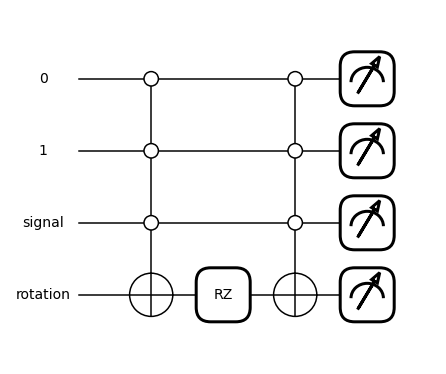

In [3]:
@qml.qnode(dev)
def dummy_qnode():
    left_controlled_phase_sift(qubits, pi)
    return qml.state()

fig, ax = qml.draw_mpl(dummy_qnode)()
fig.show()

In [4]:
def right_controlled_phase_sift(phi, ancilla_qubits):
    qml.CNOT(wires = ancilla_qubits)
    qml.RZ(phi, ancilla_qubits[-1])
    qml.CNOT(wires = ancilla_qubits)

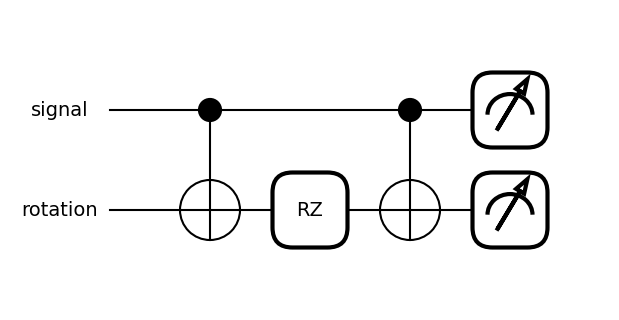

In [5]:
@qml.qnode(dev)
def dummy_qnode():
    right_controlled_phase_sift(pi, ancilla_qubits)
    return qml.state()

fig, ax = qml.draw_mpl(dummy_qnode)()
fig.show()

In [6]:
def U(qubits, bit_string):
    ctrl_qubits = qubits[:-1]
    
    for qubit in ctrl_qubits:
        qml.Hadamard(qubit)
    
    qml.MultiControlledX(wires = qubits, 
                         control_values = bit_string)

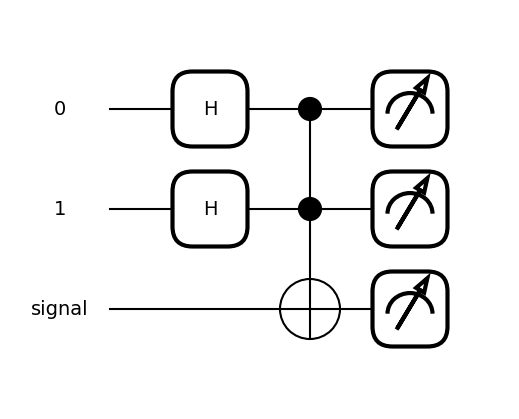

In [7]:
@qml.qnode(dev)
def dummy_qnode():
    U(qubits[:-1], '11')
    return qml.state()

fig, ax = qml.draw_mpl(dummy_qnode)()
fig.show()

In [8]:
def U_dag(qubits, bit_string): 
    ctrl_qubits = qubits[:-1]
    
    qml.MultiControlledX(wires = qubits, 
                         control_values = bit_string)
    
    for qubit in ctrl_qubits:
        qml.Hadamard(qubit)

## What is the polynomial and how does it give the angels in this 2-qubit case?

In this 2-qubit case, the singular value is $\frac{1}{\sqrt{2^2}} = \frac{1}{2}$. Thus we want to have a function $f \colon [-1, 1] \to [-1, 1]$ which maps $f(\pm \frac{1}{2}) = \mp 1$. 

When we are able to do this singular value transformation, we have a high probability of measuring the searched element.

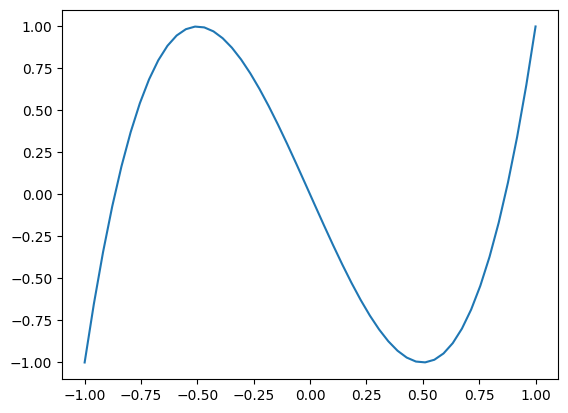

In [9]:
import matplotlib.pyplot as plt
x = np.linspace(-1, 1)
P = np.polynomial.Chebyshev((0, 0, 0, 1)) # 3rd Chebyshev polynomial
y = P(x)
plt.plot(x, y)

In [10]:
P

Chebyshev([0., 0., 0., 1.], domain=[-1,  1], window=[-1,  1])

Now [Lemma 6 (Chebyshev polynomials in QSP)](https://dl.acm.org/doi/pdf/10.1145/3313276.3316366) says that if we have a pure Chebyshev polynomial (such as $T_3$ in this case), then the first rotation is $(1 - d)\frac{\pi}{2}$ and all the rest are $\frac{\pi}{2}$. Now $d = 3$ because $T_3$ is the polynomial which solves two qubit Grover search.

In [11]:
@qml.qnode(dev)
def full_circuit():
    
    # By default Pennylane divides by 2
    angle1 = (1-d)*pi
    angle2 = pi

    left_controlled_phase_sift(qubits, angle1)
    U(qubits[:-1], bit_string)

    for _ in range((d-1)//2):
        right_controlled_phase_sift(angle2, ancilla_qubits)
        U_dag(qubits[:-1], bit_string)
        left_controlled_phase_sift(qubits, angle2)
        U(qubits[:-1], bit_string)

    return qml.probs()
    return qml.probs(system_qubits) # This shows the correct result clearly

In [ ]:
full_circuit()

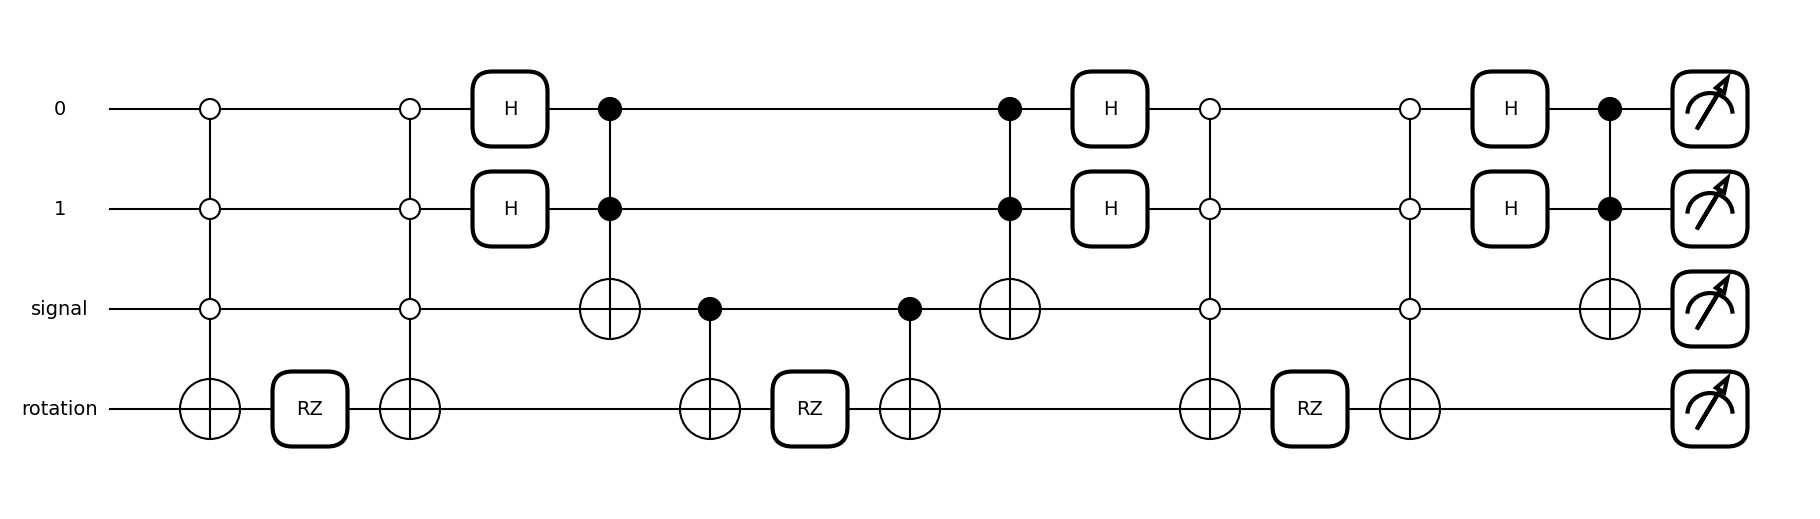

In [12]:
fig, ax = qml.draw_mpl(full_circuit)()
fig.show()

In [13]:
result = full_circuit()
bit_strings = [format(i, '0' + str(int(np.log2(len(result)))) + 'b') for i in range(len(result))]
dictionary = dict(zip(bit_strings, result))
print()
for key in dictionary:
    print(key, dictionary[key])


0000 0.0
0001 0.0
0010 0.0
0011 0.0
0100 0.0
0101 0.0
0110 0.0
0111 0.0
1000 0.0
1001 0.0
1010 0.0
1011 0.0
1100 0.0
1101 0.0
1110 0.9999999999999991
1111 0.0


The signal qubit has been flipped to $1$ as a result of finding the marked element. The rotation qubit remains in $0$ as it is only used for rotations.